In [2]:
import os
import pickle
import numpy as np
from scipy import interp
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC

In [3]:
CHANNELS = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FCz', 'FC6', 'T7', 'C3', 'Cz', 'C4',
            'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

Define method for grid search with different classification methods to find their optimal parameters

In [4]:
def perform_logistic_regression(X, y, n_splits, score):
    # Grid search with logistic regression
    lr = LogisticRegression(C=1.0)

    # GridSearch for liblinear solver
    C_range = [0.1, 1, 10, 100, 1000, 10000]
    penalty_options = ['l1', 'l2']
    fit_intercept_options = [True, False]
    solver_option = ['liblinear']
    class_weight_option = ['auto', '']

    param_grid = dict(C=C_range, penalty=penalty_options, fit_intercept=fit_intercept_options, solver=solver_option)

    # solver_options = ['newton-cg', 'lbfgs', 'sag', 'saga']
    # multi_class_options = ['ovr', 'multinomial']
    # class_weight_options = [None, 'balanced']

    # param_grid = dict(solver = solver_options, multi_class = multi_class_options, class_weight = class_weight_options)

    best_params = perform_grid_search(lr, X, y, score, n_splits, param_grid, 'Logistic Regression')
    
    return best_params
    

def perform_lda(X, y, n_splits, score):
    lda = LinearDiscriminantAnalysis()

    solver_options = ['lsqr']
    #shrinkage_options = [None, 'auto']
    shrinkage = np.arange(0.0, 1.05, 0.05)
    
    param_grid = dict(solver=solver_options, shrinkage=shrinkage)

    best_params = perform_grid_search(lda, X, y, score, n_splits, param_grid, 'LDA')
    
    return best_params
    

def perform_svc(X, y, n_splits, score):
    svc = SVC()
    
    param_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                         'C': [1, 10, 100, 1000]},
                        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    
    best_params = perform_grid_search(svc, X, y, score, n_splits, param_grid, 'SVC')
    
    return best_params

    
def perform_grid_search(clf, X, y, score, n_splits, param_grid, name, verbose=False):
    
    cv = StratifiedKFold(n_splits=10)
    
    grid_clf = GridSearchCV(clf, param_grid, cv=cv, scoring=score)
    grid_clf.fit(X, y)
    
    if verbose:
        print("# Tuning parameters for %s" % name)
        print()
        # best results
        print("The best parameters are %s with a score of %0.2f" \
              % (grid_clf.best_params_, grid_clf.best_score_))
        print()
        # complete results
        means = grid_clf.cv_results_['mean_test_score']
        stds = grid_clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid_clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print("\n")
    
    return grid_clf.best_params_

In [5]:
def run_evaluation(clf, X, y, n_splits, score='accuracy', pos_label=1):
    
    results = []
    
    for iteration in range(0, 10):
        
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=iteration)

        # Variable for accuracy score
        mean_score = 0
        
        for train, test in cv.split(X, y):
            
            # Compute accuracy score
            y_pred = clf.fit(X[train], y[train]).predict(X[test])
            
            if score is 'accuracy':
                mean_score += accuracy_score(y[test], y_pred)
            elif score is 'precision':
                mean_score += precision_score(y[test], y_pred, pos_label=pos_label)
            elif score is 'recall':
                mean_score += recall_score(y[test], y_pred, pos_label=pos_label)

        # Mean accuracy
        mean_score /= n_splits
        
        results.append(mean_score)
            
    return results

In [6]:
def run_set_of_evaluations(datasets, n_splits, optimize_score, evaluate_scores, pos_label, name):
    
    # initialize result dictionary and lists for each score
    results = {}
    
    for score in evaluate_scores:
        results[score] = []
    
    # evaluate each dataset
    for dataset in datasets:
        
        X, y = dataset.get_features_and_labels('Consc_Group')
        
        # parameter optimization
        best_params_lda = perform_lda(X, y, n_splits, optimize_score)
        best_params_lr = perform_logistic_regression(X, y, n_splits, optimize_score)

        lda = LinearDiscriminantAnalysis(**best_params_lda)
        lr = LogisticRegression(**best_params_lr)
        
        # evaluate best parameters on each score
        for score in evaluate_scores:

            results_dataset = []

            results_lda = run_evaluation(lda, X, y, n_splits, score, pos_label)
            results_lr = run_evaluation(lr, X, y, n_splits, score, pos_label)

            results_dataset.append(results_lda)
            results_dataset.append(results_lr)

            results[score].append(results_dataset)
            

    # result presentation
    
    xtick_labels = []
    
    for dataset in datasets:
        xtick_labels.append(dataset.description)
    
    for score in evaluate_scores:
        
        results[score] = np.array(results[score])
        
        means = np.mean(results[score], axis=2)
        stds = np.std(results[score], axis=2)

        print('Folds: %i\nOptimized: %s\nScore: %s' % (n_splits, optimize_score, score))
        print(means[:,0])
        print(means[:,1])
        
        print(stds[:,0])
        print(stds[:,1])
        
        ind = np.arange(len(means))
        width = 0.35

        fig, ax = plt.subplots()
        rects1 = ax.bar(ind - width/2, means[:,0], width, yerr=stds[:,0], color='CornFlowerBlue', label='LDA', capsize=5)
        rects2 = ax.bar(ind + width/2, means[:,1], width, yerr=stds[:,1], color='Crimson', label='LR', capsize=5)

        ax.set_ylabel(score.title())
        # ax.set_title('%s by instruction condition and classifier' % score)
        ax.set_xticks(ind)
        ax.set_xticklabels(xtick_labels)
        ax.legend()

        plot_path = os.path.abspath(os.path.join(image_directory, name + '_' + score + '_lr_lda.png'))

        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        
    return results
    

### Evaluation of IntErr2 data

Set important directories.

In [7]:
working_directory = 'L:/int_err2'
current_path = os.path.abspath(working_directory)
image_directory = os.path.abspath(os.path.join(current_path, 'images'))
pickle_directory = os.path.abspath(os.path.join(current_path, 'pickles'))
data_directory = os.path.abspath(os.path.join(current_path, 'data'))

Load separability indices.

In [9]:
std_comp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'std_comp_corr.pkl'))
with open(std_comp_corr_file, 'rb') as pickle_file:
    std_comp_corr = pickle.load(pickle_file)
    
std_incomp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'std_incomp_corr.pkl'))
with open(std_incomp_corr_file, 'rb') as pickle_file:
    std_incomp_corr = pickle.load(pickle_file)
    
alt_comp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'alt_comp_corr.pkl'))
with open(alt_comp_corr_file, 'rb') as pickle_file:
    alt_comp_corr = pickle.load(pickle_file)
    
alt_incomp_corr_file = os.path.abspath(os.path.join(pickle_directory, 'alt_incomp_corr.pkl'))
with open(alt_incomp_corr_file, 'rb') as pickle_file:
    alt_incomp_corr = pickle.load(pickle_file)

In [10]:
std_comp_corr.extract_features([[112, 152]], CHANNELS, 'Consc_Group')
std_incomp_corr.extract_features([[-60, -40], [112, 148]], CHANNELS, 'Consc_Group')
alt_comp_corr.extract_features([[112, 152], [468, 484]], CHANNELS, 'Consc_Group')
alt_incomp_corr.extract_features([[348, 380]], CHANNELS, 'Consc_Group')
# alt_incomp_corr.extract_features([[-20, 0], [348, 380]], CHANNELS, 'Consc_Group')

std_comp_corr.description = 'STD\n(congruent)'
std_incomp_corr.description = 'STD\n(incongruent)'
alt_comp_corr.description = 'ALT\n(congruent)'
alt_incomp_corr.description = 'ALT\n(incongruent)'

C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'prec

Folds: 10
Optimized: accuracy
Score: accuracy
[0.67166667 0.65766667 0.63866667 0.60633333]
[0.66133333 0.502      0.681      0.51333333]
[0.02418677 0.03809491 0.02334286 0.02024571]
[0.01550627 0.02725191 0.03703002 0.03927114]
Folds: 10
Optimized: accuracy
Score: precision
[0.71366667 0.73583333 0.68083333 0.653     ]
[0.6905     0.5655     0.76083333 0.53983333]
[0.05529115 0.06237988 0.04725963 0.0310716 ]
[0.02179513 0.04282425 0.02189939 0.07874519]
Folds: 10
Optimized: accuracy
Score: recall
[0.72333333 0.65666667 0.72       0.67      ]
[0.79666667 0.49666667 0.69333333 0.56333333]
[0.02603417 0.03349959 0.02666667 0.0314466 ]
[0.01795055 0.05259911 0.05120764 0.05467073]


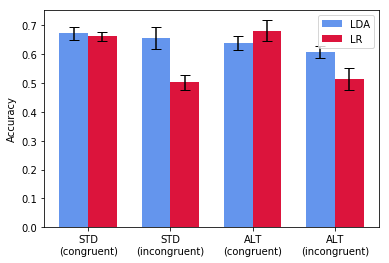

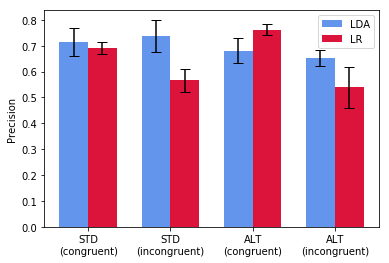

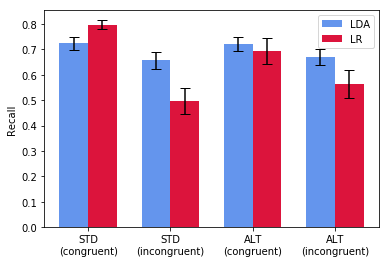

In [11]:
results = run_set_of_evaluations([std_comp_corr, std_incomp_corr, alt_comp_corr, alt_incomp_corr], 10, 'accuracy', ['accuracy', 'precision', 'recall'], 1, 'interr2')

In [12]:
print(np.round(results['accuracy'], 2))

eval_results_file = os.path.abspath(os.path.join(data_directory, 'results_10_accuracy.csv'))

for dataset in results['accuracy']:
    np.savetxt(eval_results_file, np.round(dataset, 2), delimiter=",")

[[[0.67 0.68 0.71 0.67 0.67 0.67 0.61 0.67 0.69 0.68]
  [0.63 0.64 0.67 0.66 0.68 0.67 0.67 0.65 0.68 0.67]]

 [[0.7  0.71 0.62 0.68 0.67 0.63 0.61 0.71 0.65 0.61]
  [0.52 0.54 0.47 0.52 0.5  0.53 0.47 0.49 0.52 0.46]]

 [[0.62 0.67 0.65 0.65 0.65 0.62 0.68 0.63 0.63 0.6 ]
  [0.73 0.67 0.71 0.67 0.69 0.61 0.66 0.74 0.68 0.65]]

 [[0.59 0.59 0.65 0.61 0.63 0.58 0.6  0.61 0.6  0.61]
  [0.5  0.51 0.5  0.54 0.56 0.51 0.5  0.45 0.58 0.48]]]


### Evaluation of IntErr1 data

Set important directories.

In [10]:
working_directory = 'L:/int_err'
current_path = os.path.abspath(working_directory)
image_directory = os.path.abspath(os.path.join(current_path, 'images'))
pickle_directory = os.path.abspath(os.path.join(current_path, 'pickles'))
data_directory = os.path.abspath(os.path.join(current_path, 'data'))

Load separability indices.

In [11]:
consc_std_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_std_corr.pkl'))
with open(consc_std_corr_file, 'rb') as pickle_file:
    consc_std_corr = pickle.load(pickle_file)
    
consc_rv_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_rv_corr.pkl'))
with open(consc_rv_corr_file, 'rb') as pickle_file:
    consc_rv_corr = pickle.load(pickle_file)  

consc_rr_corr_file = os.path.abspath(os.path.join(pickle_directory, 'consc_rr_corr.pkl'))
with open(consc_rr_corr_file, 'rb') as pickle_file:
    consc_rr_corr = pickle.load(pickle_file)  

In [12]:
consc_std_corr.extract_features([[124, 188], [192, 212]], CHANNELS, 'Consc_Group')
# A: [160, 180], [204, 240] - B: [120, 192], [200, 220] - C: [246, 278]
consc_rv_corr.extract_features([[120, 192], [200, 220]], CHANNELS, 'Consc_Group')
# A: [160, 180], [204, 240] - B: [112, 168], [172, 212]
consc_rr_corr.extract_features([[112, 220]], CHANNELS, 'Consc_Group')
# A: [112, 168], [172, 212]

C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mike\AppData\Local\conda\conda\envs\seegnature\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Folds: 10
Optimized: accuracy
Score: accuracy
[0.61666667 0.724      0.65316667]
[0.6775     0.707      0.69833333]
[0.03284644 0.02458771 0.0303173 ]
[0.03622652 0.05192837 0.0500999 ]
Folds: 10
Optimized: accuracy
Score: precision
[0.641      0.72833333 0.662     ]
[0.66933333 0.71183333 0.72416667]
[0.05711684 0.07405328 0.05729941]
[0.07160928 0.06377238 0.0725    ]
Folds: 10
Optimized: accuracy
Score: recall
[0.54       0.7        0.65166667]
[0.665      0.71333333 0.665     ]
[0.04666667 0.03248931 0.0328718 ]
[0.04245913 0.07916228 0.05600099]


{'accuracy': array([[[0.61      , 0.59666667, 0.57166667, 0.63166667, 0.59666667,
          0.64166667, 0.69666667, 0.60666667, 0.62166667, 0.59333333],
         [0.70666667, 0.66333333, 0.69666667, 0.615     , 0.68      ,
          0.71666667, 0.705     , 0.60666667, 0.69666667, 0.68833333]],
 
        [[0.78      , 0.71833333, 0.70833333, 0.74666667, 0.72166667,
          0.705     , 0.71833333, 0.69166667, 0.70666667, 0.74333333],
         [0.61833333, 0.755     , 0.705     , 0.68166667, 0.69833333,
          0.70166667, 0.73833333, 0.62666667, 0.77666667, 0.76833333]],
 
        [[0.63      , 0.66166667, 0.65833333, 0.62166667, 0.67666667,
          0.67166667, 0.65666667, 0.59166667, 0.65666667, 0.70666667],
         [0.705     , 0.69833333, 0.67166667, 0.71833333, 0.76333333,
          0.74166667, 0.63      , 0.635     , 0.64333333, 0.77666667]]]),
 'precision': array([[[0.66666667, 0.61666667, 0.49333333, 0.65      , 0.68333333,
          0.66666667, 0.68333333, 0.6       , 0.7 

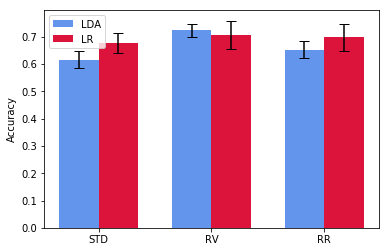

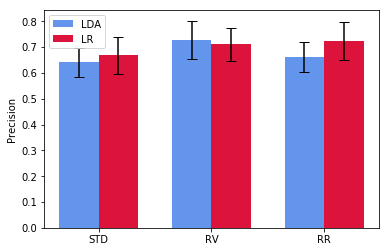

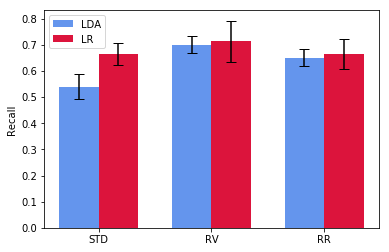

In [38]:
run_set_of_evaluations([consc_std_corr, consc_rv_corr, consc_rr_corr], 10, 'accuracy', ['accuracy', 'precision', 'recall'], 0, 'interr1')